In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from load_dataset import load_dataset

2024-04-12 19:19:56.527451: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-12 19:19:57.298921: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

2024-04-12 19:19:59.850814: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-12 19:19:59.899014: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-12 19:19:59.899204: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
train_ds, val_ds, test_ds = load_dataset()

Found 19656 files belonging to 40 classes.
Using 13760 files for training.


2024-04-12 19:20:03.057377: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-12 19:20:03.057584: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-12 19:20:03.057754: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Found 19656 files belonging to 40 classes.
Using 5896 files for validation.


2024-04-12 19:20:33.548762: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


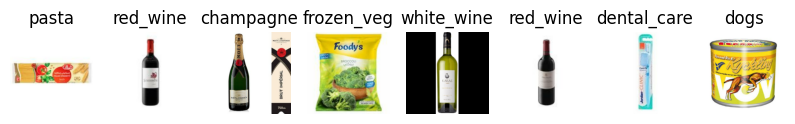

In [7]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(8):
    ax = plt.subplot(1, 8, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")

In [8]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(256, 256, 3),
                                               include_top=False,
                                               weights='imagenet')

/tmp/ipykernel_36399/2661107847.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(input_shape=(256, 256, 3),


In [9]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

2024-04-12 19:20:49.817608: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


(32, 8, 8, 1280)


In [10]:
base_model.trainable = False

In [11]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [12]:
prediction_layer = tf.keras.layers.Dense(40, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 40)


In [13]:
inputs = tf.keras.Input(shape=(256, 256, 3))
preprocess =  tf.keras.layers.Rescaling(1./255)(inputs)
x = base_model(preprocess, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(40, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [14]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 8, 8, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 40)             │        51,240 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,309,224 (8.81 MB)

 Trainable params: 51,240 (200.16 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [16]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [17]:
history = model.fit(train_ds,
                    epochs=3,
                    validation_data=val_ds)

Epoch 1/3


I0000 00:00:1712924627.650824   36461 service.cc:145] XLA service 0x72a174002460 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1712924627.650860   36461 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1070, Compute Capability 6.1
2024-04-12 19:23:47.768448: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


  3/430 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.0260 - loss: 4.0831      

I0000 00:00:1712924632.642230   36461 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


430/430 ━━━━━━━━━━━━━━━━━━━━ 36s 65ms/step - accuracy: 0.0753 - loss: 3.6456 - val_accuracy: 0.3299 - val_loss: 2.6710
Epoch 2/3
430/430 ━━━━━━━━━━━━━━━━━━━━ 24s 55ms/step - accuracy: 0.3279 - loss: 2.5709 - val_accuracy: 0.4482 - val_loss: 2.1519
Epoch 3/3
430/430 ━━━━━━━━━━━━━━━━━━━━ 23s 54ms/step - accuracy: 0.4369 - loss: 2.1100 - val_accuracy: 0.5041 - val_loss: 1.8797


In [18]:
base_model.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=2,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 8, 8, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 40)             │        51,240 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,309,224 (8.81 MB)

 Trainable params: 2,275,112 (8.68 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [19]:
history_2 = model.fit(train_ds,
                      epochs=15,
                      validation_data=val_ds,
                      callbacks=[es])

Epoch 1/15
430/430 ━━━━━━━━━━━━━━━━━━━━ 106s 168ms/step - accuracy: 0.5129 - loss: 1.7798 - val_accuracy: 0.5559 - val_loss: 1.5567
Epoch 2/15
430/430 ━━━━━━━━━━━━━━━━━━━━ 70s 161ms/step - accuracy: 0.7876 - loss: 0.7554 - val_accuracy: 0.6762 - val_loss: 1.1411
Epoch 3/15
430/430 ━━━━━━━━━━━━━━━━━━━━ 70s 162ms/step - accuracy: 0.8852 - loss: 0.4290 - val_accuracy: 0.7341 - val_loss: 0.9426
Epoch 4/15
430/430 ━━━━━━━━━━━━━━━━━━━━ 69s 160ms/step - accuracy: 0.9438 - loss: 0.2321 - val_accuracy: 0.7686 - val_loss: 0.8137
Epoch 5/15
430/430 ━━━━━━━━━━━━━━━━━━━━ 69s 160ms/step - accuracy: 0.9780 - loss: 0.1226 - val_accuracy: 0.7690 - val_loss: 0.7997
Epoch 6/15
430/430 ━━━━━━━━━━━━━━━━━━━━ 69s 160ms/step - accuracy: 0.9870 - loss: 0.0680 - val_accuracy: 0.8018 - val_loss: 0.7436
Epoch 7/15
430/430 ━━━━━━━━━━━━━━━━━━━━ 70s 162ms/step - accuracy: 0.9939 - loss: 0.0452 - val_accuracy: 0.8150 - val_loss: 0.7009
Epoch 8/15
430/430 ━━━━━━━━━━━━━━━━━━━━ 71s 164ms/step - accuracy: 0.9954 - loss: 

In [20]:
results = model.evaluate(test_ds)

92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.7542 - loss: 1.0311


In [21]:
results

[1.021094560623169, 0.7557744383811951]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


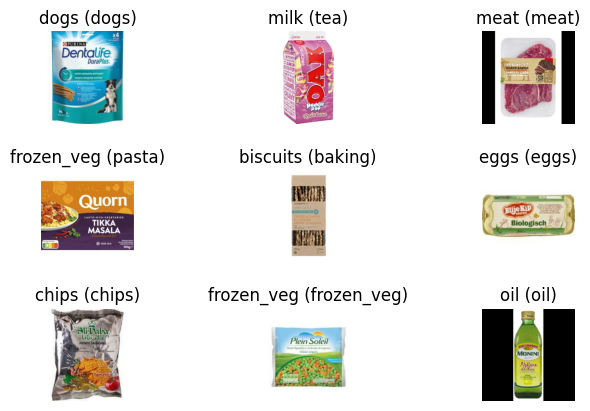

In [27]:
IMAGE_NUM = 2
for i, (images, labels) in enumerate(test_ds):
    if i == 9:
        break
    ax = plt.subplot(3, 3, i + 1)
    im = np.expand_dims(images[IMAGE_NUM].numpy(), axis=0)
    prediction = class_names[np.argmax(model.predict(im)[0])]
    plt.imshow(images[IMAGE_NUM, ...].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels.numpy()[IMAGE_NUM])] + f' ({prediction})')
    plt.axis("off")
    plt.subplots_adjust(left=None, bottom=None, right=1.1, top=None, wspace=None, hspace=0.5)


In [28]:
%%capture
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

predictions = np.array([])
labels =  np.array([])
for x, y in test_ds:
  predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis=1)])
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

cm = confusion_matrix(labels, predictions, normalize="true")

2024-04-12 19:40:52.384781: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


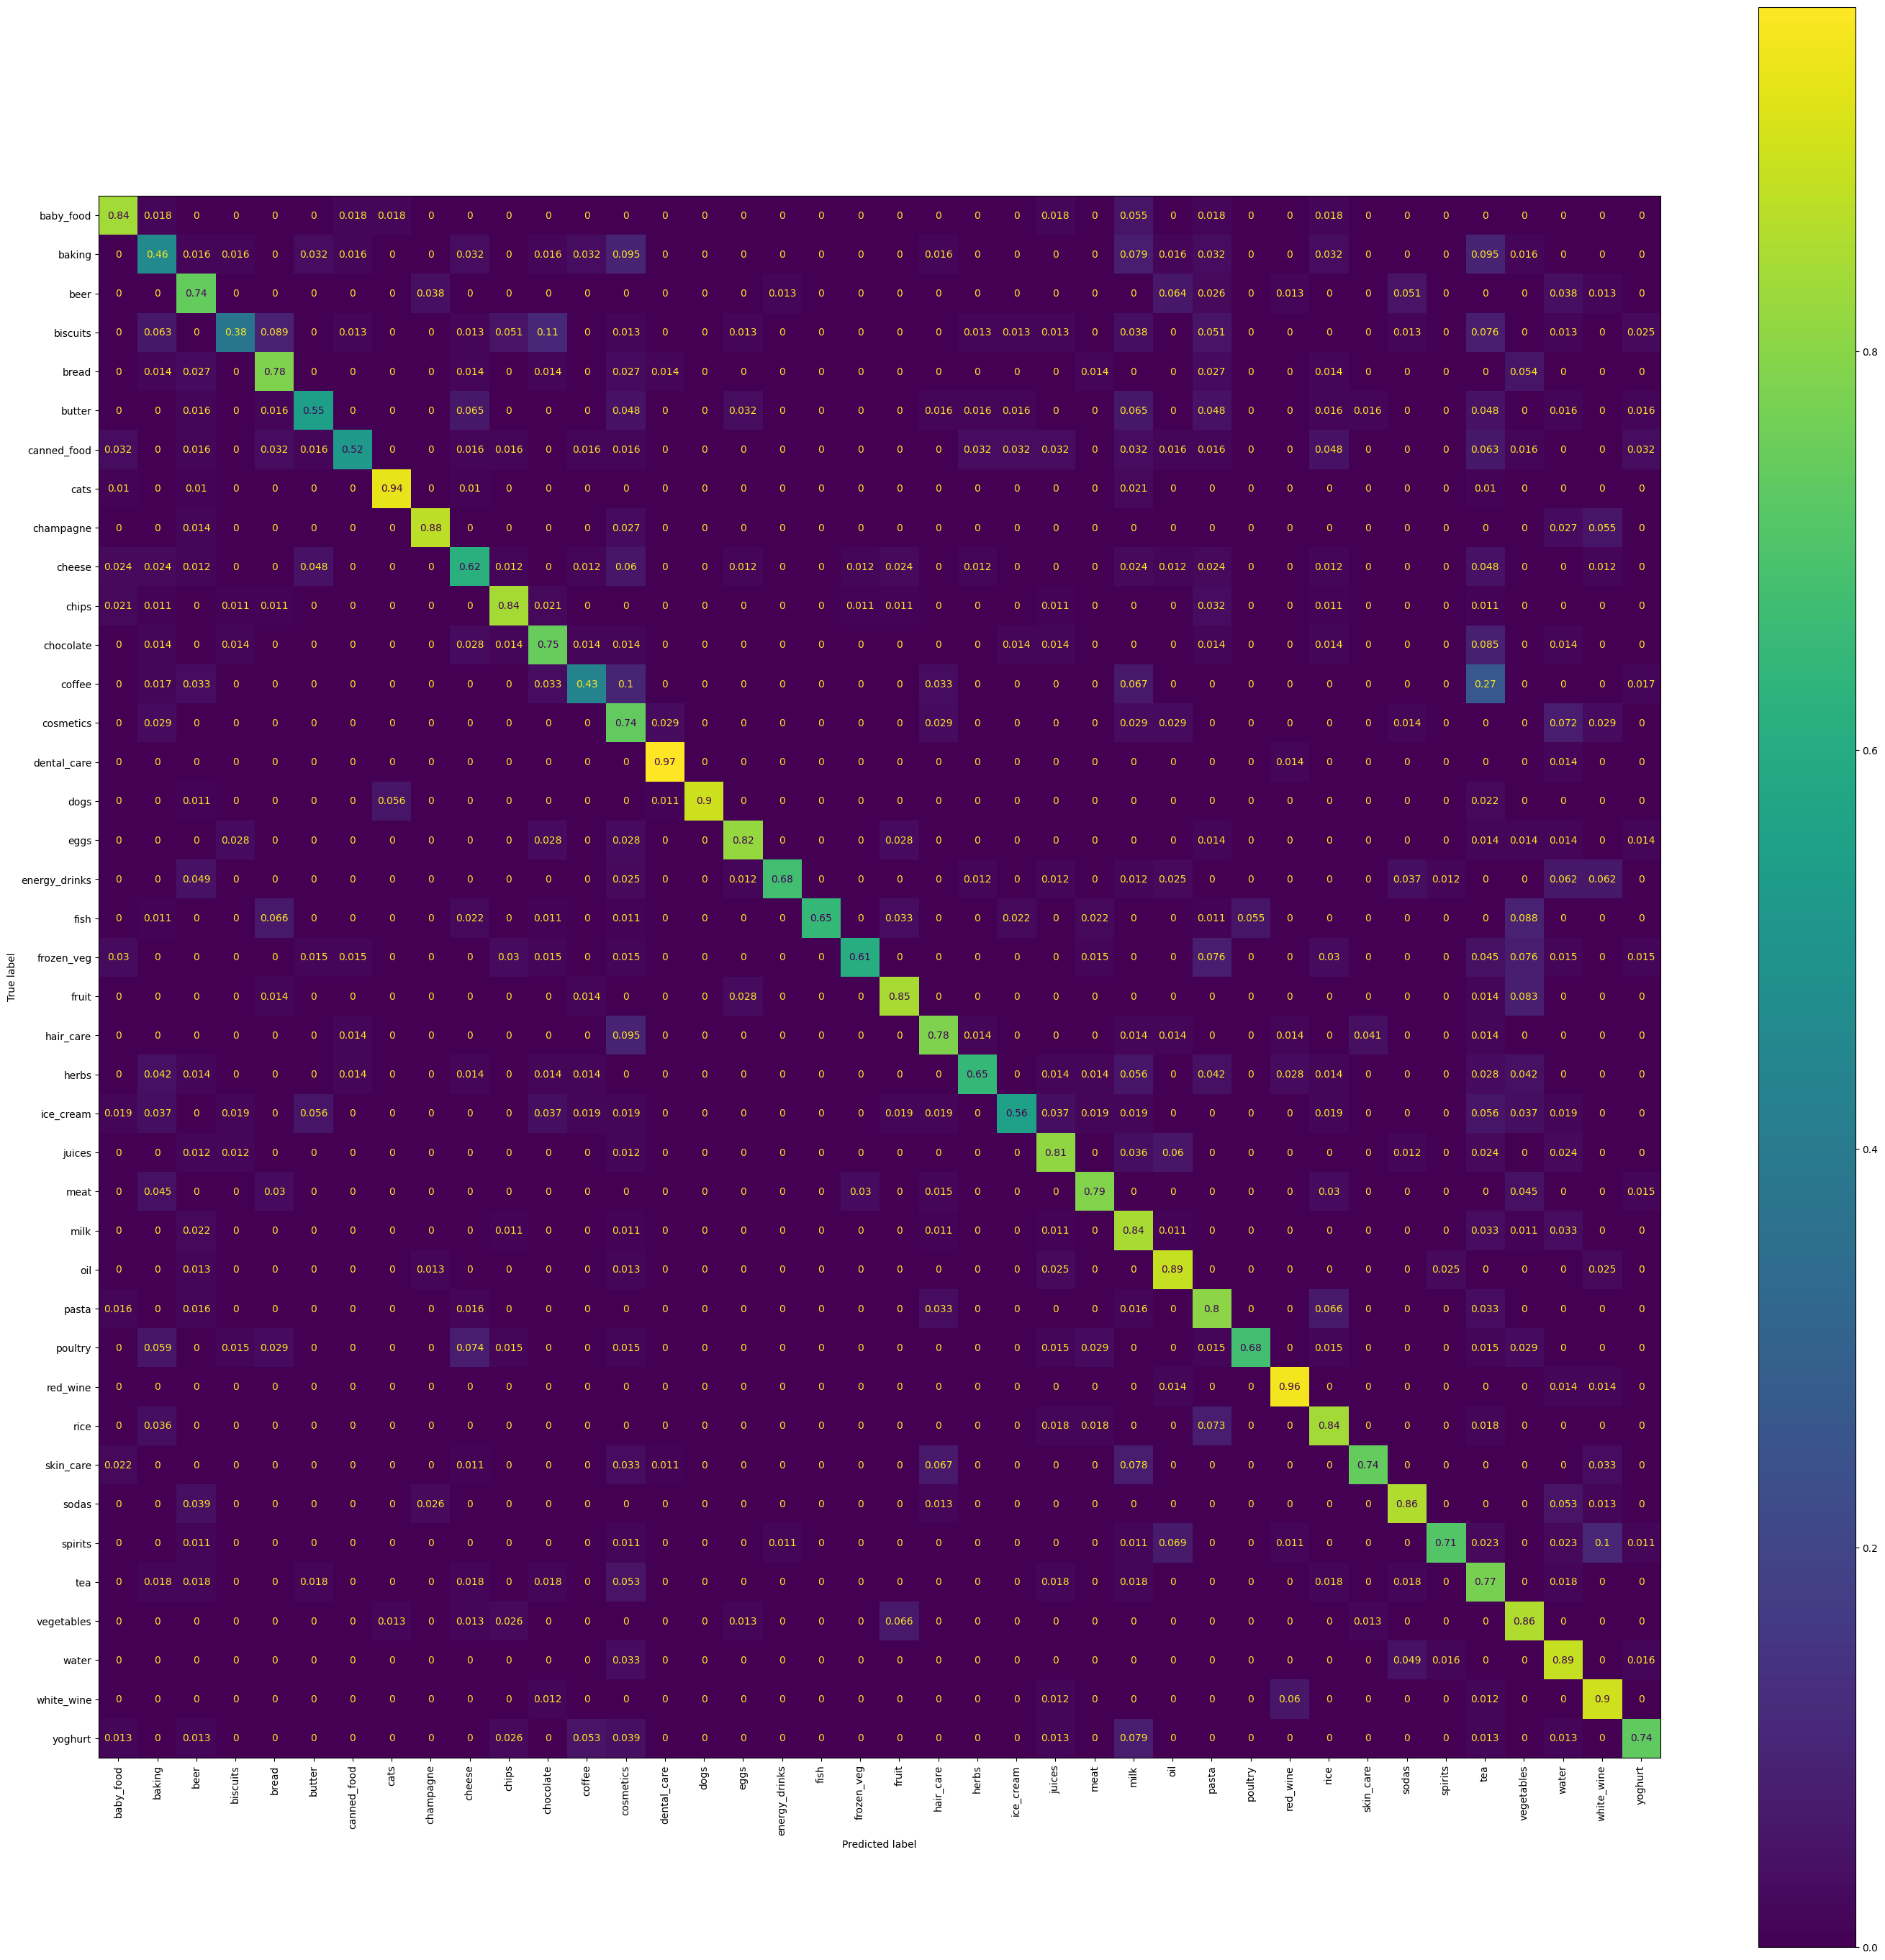

In [29]:
fig, ax = plt.subplots(figsize=(35, 35))
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_ds.class_names)
cmd.plot(ax=ax)
plt.xticks(rotation=90)
plt.show()

In [31]:
model.save('ready_models/mobile_net_v2.keras')